# Random Projections

### Rishi Advani, Madison Crim, Sean O'Hagan

#### July 24, 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from tqdm import tqdm, trange

In [2]:
%matplotlib inline

## Kernel PCA

In [3]:
from sklearn.decomposition import KernelPCA
# from mpl_toolkits.mplot3d import Axes3D

In [4]:
# TODO

## Kernel SVM

In Kernel PCA, we are trying to cluster the data and visualize it better. Now, we are going to use the Support Vector Machine (SVM) structure to explicitly classify the data.

In [5]:
from sklearn.svm import SVC

For this presentation, we will use the standard MNIST dataset, but we have confirmed our results on various other datasets as well (e.g., Fashion-MNIST, frequency statistics from a voice dataset).

Our goal is to create a classifier that learns how to 'read' hand-written digits. We will evaluate the model by giving it more samples of hand-written digits and evaluate whether it is able to correctly identify the digit from the drawing.

### read in data

In [ ]:
from sklearn.model_selection import train_test_split

In [6]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

n,d = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

### define kernel

Just like in Kernel PCA, we use a kernel matrix to allow us to make data separable in a higher dimension.

In [7]:
def generate_kernel(m=40, q=10, s=1/d, scale=True):
    q_arr = np.random.uniform(low=0.5, high=4, size=q) # multipliers for size of domain of inner uniform distribution

    if scale:
        s = s/np.var(X_train)
    std = np.sqrt(2*s)
    
    W = np.random.uniform(low=-std*q_arr, high=std*q_arr, size=(m,d,q))
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m,1))
    
    def ker(x, y):
        z1 = np.cos(np.dot(x, W) + b)
        z2 = np.cos(np.dot(y, W) + b)
        res = np.tensordot(z1, z2, axes=([1,2],[1,2])) / (m*q)
        return res
    
    return ker

### experiments

We will now use 2 distinct methods to classify the data. One is the default deterministic version of SVM provided by the scikit-learn module. The other is a randomized algorithm that we adapted from a paper by Lopez-Paz, et al. and then modified slightly in an attempt to make it more robust.

#### deterministic SVM

In [11]:
det_svm = SVC()
det_svm.fit(X_train, y_train)
det_score = det_svm.score(X_test, y_test)

In [12]:
iterations = 40
det_times = np.empty((iterations))

for i in trange(iterations):
    start = perf_counter()
    det_svm = SVC()
    det_svm.fit(X_train, y_train)
    _ = det_svm.score(X_test, y_test)
    det_times[i] = perf_counter() - start

100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


#### randomized SVM

In [14]:
iterations = 50
scores = np.empty((iterations))
times = np.empty((iterations))
    

for i in trange(iterations):
    start = perf_counter()
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(X_train, y_train)
    scores[i] = random_svm.score(X_test, y_test)
    times[i]= perf_counter() - start

stat = np.empty(7)
stat[0] = np.min(scores)
stat[1] = np.quantile(scores, 0.25)
stat[2] = np.median(scores)
stat[3] = np.quantile(scores, 0.75)
stat[4] = np.max(scores)
stat[5] = np.mean(scores)
stat[6] = np.std(scores)

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


### results

#### deterministic SVM

In [55]:
print(f'Accuracy: \t{det_score} \nTime: \t\t{np.mean(det_times)}')

Accuracy: 	0.905 
Time: 		0.6659254374999932


#### randomized SVM

In [54]:
print(f'Mean accuracy: \t{stat[5]} \nStdev: \t\t{stat[6]} \nMean time: \t{np.mean(times)}\n')
print(f'Accuracy stats: \n  Q0: \t{stat[0]} \n  Q1: \t{stat[1]} \n  Q2: \t{stat[2]} \n  Q3: \t{stat[3]} \n  Q4: \t{stat[4]}')

Mean accuracy: 	0.8167 
Stdev: 		0.021693547427749083 
Mean time: 	0.8894944399999986

Accuracy stats: 
  Q0: 	0.765 
  Q1: 	0.8 
  Q2: 	0.82 
  Q3: 	0.835 
  Q4: 	0.855


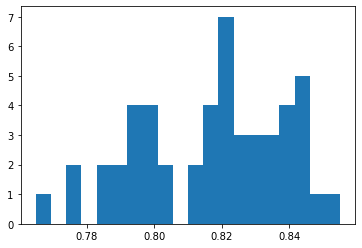

In [36]:
plt.hist(scores, bins=20);

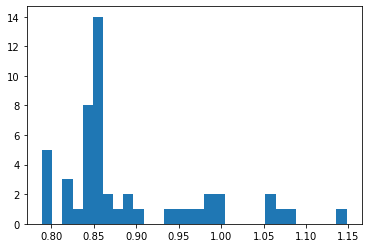

In [35]:
plt.hist(times, bins=30);

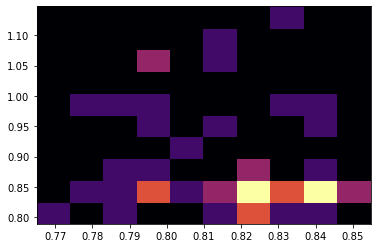

In [23]:
plt.hist2d(scores, times, bins=10, cmap='inferno');

We see that our randomized algorithm does not perform quite as well as the default deterministic version, but it is able to come quite close.

## RSVD/RID performance

In [19]:
# TODO